#  Compare input file data

In [124]:
import errno
import h5py
import multiprocessing
import numpy as np
import os
import time
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import utilities
from salishsea_tools import viz_tools
from scipy.interpolate import griddata
import numpy.ma as ma

In [121]:
wave_files = ['temp/ww3test.nc'] 
dirname = 'temp/'
"""Generate Wave Watch 3 input files

:arg wave_files: listofString; WW3 netcdf file paths
:type list: :py:class:'list'

:arg dirname: Output file directory
:type string: :py:class:'str'

:arg compression_level: compression level for output file (Integer[1,9])
:type integer: :py:class:'int'

:returns: None
:rtype: :py:class:`NoneType'
"""
# create hdf5 file and create tree structure
#f     = h5py.File(f'{dirname}ww3.hdf5', 'w')
#times = f.create_group('Time')
#mwp   = f.create_group('/Results/mean wave period')
#swh   = f.create_group('/Results/significant wave height')
#wc    = f.create_group('/Results/whitecap coverage')

# since we are looping through the source files by day, we want to keep track of the
# number of records we have made so that we can allocate the correct child names
attr_counter = 0

bar = utilities.statusbar('Creating WW3 parameters file ...', maxval = len(wave_files))
for wave_file in bar(wave_files):
    # load WW3 netcdf source file using xarray
    WW3 = xr.open_dataset(wave_file)

    # SalishSeaCast lat-lon data
    NEMO_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02')


# WW3 data coordinates
    lat_lon_mesh = np.meshgrid(WW3.MAPSTA.latitude.values, WW3.MAPSTA.longitude.values)    
    points = np.array([lat_lon_mesh[0].T.ravel(), lat_lon_mesh[1].T.ravel()-360]).T

    # NEMO lat lon grids tuple
    xi = (NEMO_grid.latitude.values, NEMO_grid.longitude.values)

    #convert xarray DataArrays to numpy arrays
    mean_wave_array = WW3.t02.values
    cc = np.where(np.isnan(mean_wave_array[0].ravel()))
    data = np.delete(mean_wave_array[0].ravel(), cc, 0)
    points = np.delete(points, cc, 0)
    # create an interpolated array of the 1st slice so you can stack it onto the rest
    mean_wave = np.expand_dims(griddata(points, data, xi, method='cubic'),0)

Creating WW3 parameters file ... 100% (1 of 1) |################|Time:  0:00:01


In [127]:
land_mask = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02').tmaskutil.isel(time = 0).values[1:897:,1:397]
masked_data = ma.masked_array(mean_wave_array[0], np.logical_not(land_mask)) 

MaskError: Mask and data not compatible: data size is 378092, mask size is 354816.

In [128]:
mean_wave_array[0].shape

(661, 572)

/home/abhudia/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


1.1363636363636362

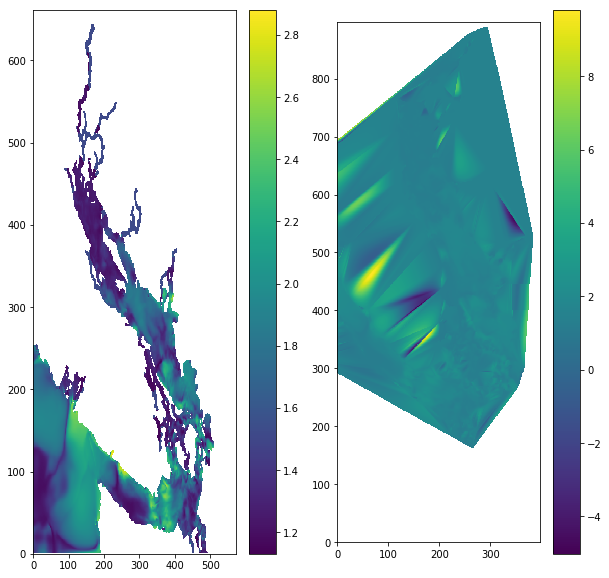

In [122]:
fig = plt.figure(figsize = (10,10) )
ax = plt.subplot(1,2,1)
plt.pcolormesh(mean_wave_array[0])
plt.colorbar()
ax1 = plt.subplot(1,2,2)
plt.pcolormesh(mean_wave[0])
plt.colorbar()
viz_tools.set_aspect(ax1)

1.1363636363636362

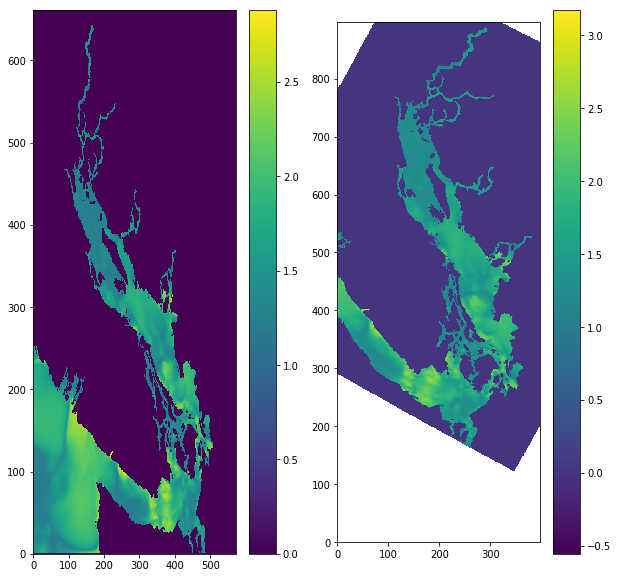

In [58]:
fig = plt.figure(figsize = (10,10) )
ax = plt.subplot(1,2,1)
plt.pcolormesh(mean_wave_array[0])
plt.colorbar()
ax1 = plt.subplot(1,2,2)
plt.pcolormesh(mean_wave[0])
plt.colorbar()
viz_tools.set_aspect(ax1)

In [59]:
x =   np.array([[9.19632, 9.62141, 10.0829,np.isnan,np.isnan],
    [9.21164, 9.64347, 10.1392, 10.5698,np.isnan],
    [9.22175, 9.65439, 10.1423, 10.6301, 11.0323],
    [9.21632, 9.67060, 10.1474, 10.6230, 11.0818]])

y =  np.array([[11.5466,11.6485,11.7619,np.isnan,np.isnan],
    [12.4771, 12.5460, 12.5453, 12.7142,np.isnan],
    [13.5578, 13.5581, 13.5505, 13.5309, 13.6081],
    [14.5653, 14.5504, 14.5036, 14.5145, 14.5060]])

z = np.array([[0.466113, 0.0484404, -0.385355,np.isnan,np.isnan],
    [0.366125, -0.160165, -0.548668, -0.888301,np.isnan],
    [-0.0970777, -0.346734, -0.826576, -1.08412, -1.33129],
    [-0.259981, -0.586938, -1.03477, -1.32384, -1.61500]])

In [61]:
x.shape

(4, 5)

In [62]:
x=x.ravel()              #Flat input into 1d vector
x=list(x[x!=np.isnan])

In [63]:
len(x)

17

In [3]:
    # interpolate and stack the rest of the grids
    for grid in range(1, mean_wave_array.shape[0]):
        interp_mean_wave = griddata(points, mean_wave_array[grid].ravel(), xi, method='cubic')
        mean_wave        = np.vstack((mean_wave, np.expand_dims(interp_mean_wave,0)))

        interp_sig_wave = griddata(points, sig_wave_array[grid].ravel(), xi, method='cubic')
        sig_wave        = np.vstack((sig_wave, np.expand_dims(interp_sig_wave,0)))

        interp_whitecap = griddata(points, whitecap_array[grid].ravel(), xi, method='cubic')
        whitecap        = np.vstack((whitecap, np.expand_dims(interp_whitecap,0)))

    # cut off grid edges
    mean_wave = mean_wave[...,:,1:897:,1:397]
    sig_wave  = sig_wave[...,:,1:897:,1:397]
    whitecap  = whitecap[...,:,1:897:,1:397]

    # transpose grid (rotate 90 clockwise)
    mean_wave = np.transpose(mean_wave, [0, 2, 1])
    sig_wave  = np.transpose(sig_wave, [0, 2, 1])
    whitecap  = np.transpose(whitecap, [0, 2, 1])

    # convert nans to 0s and set datatype to float64
    mean_wave = np.nan_to_num(mean_wave).astype('float64')
    sig_wave  = np.nan_to_num(sig_wave).astype('float64')
    whitecap  = np.nan_to_num(whitecap).astype('float64')

    # load dates from netcdf file
    datelist = WW3.time.values.astype('datetime64[s]').astype(datetime)

    # make list of time arrays
    datearrays = []
    for date in datelist:
        datearrays.append(
            np.array([date.year, date.month, date.day, date.hour, date.minute, date.second]).astype('float64')
            )

    # write time values to hdf5
    for i, datearray in enumerate(datearrays):
        child_name = 'Time_' + ((5 - len(str(i + attr_counter + 1))) * '0') + str(i + attr_counter + 1)
        dset       = times.create_dataset(
            child_name,
            shape            = (6,),
            data             = datearray,
            chunks           = (6,),
            compression      = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'Maximum' : np.array([float(datearray[0])]),
            'Minimum' : np.array([-0.]),
            'Units'   : b'YYYY/MM/DD HH:MM:SS'
            } 
        dset.attrs.update(metadata)

    # write mean wave period to hdf5
    for i, dataset in enumerate(mean_wave):
        child_name = 'mean wave period_' + ((5 - len(str(i + attr_counter + 1))) * '0') + str(i + attr_counter + 1)
        dset       = mwp.create_dataset(
            child_name,
            shape            = (396, 896),
            data             = dataset,
            chunks           = (396, 896),
            compression      = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'FillValue' : np.array([0.]),
            'Maximum'   : np.array([100000.]),
            'Minimum'   : np.array([0.]),
            'Units'     : b's'
            }
        dset.attrs.update(metadata)

    # write significant wave height to hdf5
    for i, dataset in enumerate(sig_wave):
        child_name = 'significant wave height_' + ((5 - len(str(i + attr_counter + 1))) * '0') + str(i + attr_counter + 1)
        dset       = swh.create_dataset(
            child_name,
            shape            = (396, 896),
            data             = dataset,
            chunks           = (396, 896),
            compression      = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'FillValue' : np.array([0.]),
            'Maximum'   : np.array([100.]),
            'Minimum'   : np.array([-100.]),
            'Units'     : b'm'
            }
        dset.attrs.update(metadata)

    # write whitecap coverage to hdf5
    for i, dataset in enumerate(whitecap):
        child_name = 'whitecap coverage_' + ((5 - len(str(i + attr_counter + 1))) * '0') + str(i + attr_counter + 1)
        dset       = wc.create_dataset(
            child_name,
            shape            = (396, 896),
            data             = dataset,
            chunks           = (396, 896),
            compression      = 'gzip',
            compression_opts = compression_level
            )
        metadata = {
            'FillValue' : np.array([0.]),
            'Maximum'   : np.array([1.]),
            'Minimum'   : np.array([0.]),
            'Units'     : b'1'
            }
        dset.attrs.update(metadata)

    # update the accumulator
    attr_counter = attr_counter + mean_wave.shape[0]

    # clear memory
    mean_wave, sig_wave, whitecap  = None, None, None

f.close()

Creating WW3 parameters file ... 100% (1 of 1) |################|Time:  0:15:24


In [4]:
a = h5py.File('temp/ww3.hdf5')

In [15]:
np.asarray(a['Results']['significant wave height']['significant wave height_00001']).sum()

0.0

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

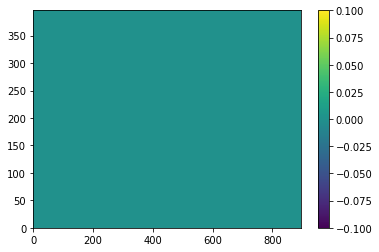

In [14]:
plt.pcolormesh(np.asarray(a['Results']['significant wave height']['significant wave height_00001']))
plt.colorbar()

In [25]:
GEM_grid  = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
NEMO_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02')

# GEM data coordinates
points = np.array([GEM_grid.latitude.values.ravel(), GEM_grid.longitude.values.ravel()-360]).T

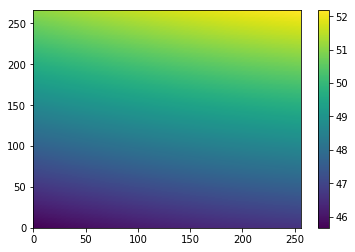

In [36]:
plt.pcolormesh(GEM_grid.latitude.values)
plt.colorbar()

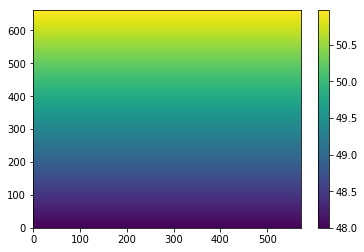

In [39]:
plt.pcolormesh(np.meshgrid(WW3.MAPSTA.latitude.values, WW3.MAPSTA.longitude.values)[0].T)
plt.colorbar()

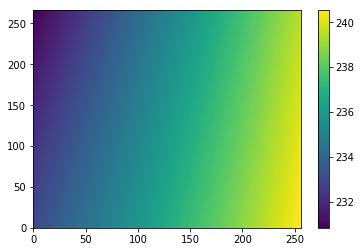

In [40]:
plt.pcolormesh(GEM_grid.longitude.values)
plt.colorbar()

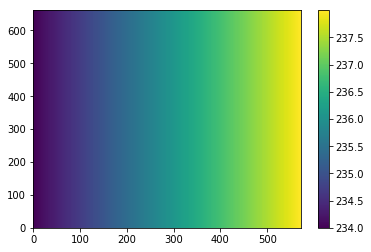

In [42]:
plt.pcolormesh(np.meshgrid(WW3.MAPSTA.latitude.values, WW3.MAPSTA.longitude.values)[1].T)
plt.colorbar()